<a href="https://colab.research.google.com/github/LuchoValr/The-effect/blob/main/cap20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regresion discontinua con minimos cuadrados ordinarios con bandwidth y kernel weight aplicado, con heteroskedasticity-robust standard errors

In [1]:
#Primero graficamos para chequear si hay discontinuidad

In [2]:
!pip install causaldata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from causaldata import gov_transfers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for causaldata: filename=causaldata-0.1.3-py3-none-any.whl size=2645603 sha256=14255c4e1e4965366c057842b6169f45c61845a82a11273cf18421fd7e10a14f
  Stored in directory: /root/.cache/pip/wheels/4a/8f/9f/13d3a7ab29b8a8c68f3e5dcc0fe00d0e8eef62fc508a20c7c6
Successfully built causaldata


In [3]:
d = gov_transfers.load_pandas().data

In [4]:
#Cut at 0, and 15 places on either side
edges = np.linspace(-0.02, 0.02, 31)
d['Bins'] =pd.cut(d['Income_Centered'], bins = edges)

In [5]:
#Mean within bins
binned = d.groupby(['Bins']).agg('mean')

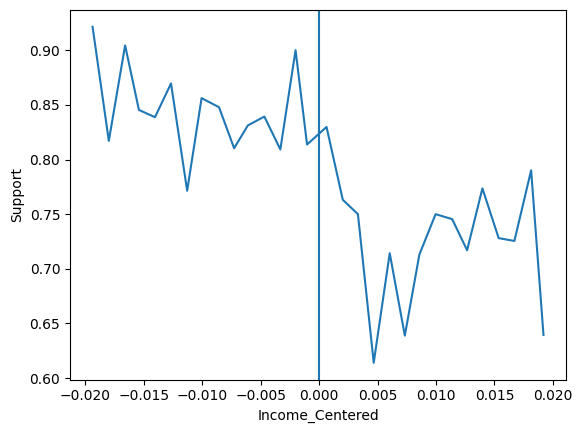

In [6]:
#And plot
sns.lineplot(x = binned['Income_Centered'],
             y = binned['Support'])
#Add vertical line at cutoff
plt.axvline(0, 0, 1)

In [7]:
#Realizando la regresion

In [8]:
import statsmodels.formula.api as smf

In [9]:
d = gov_transfers.load_pandas().data

In [10]:
#Run the polynomial model
m1 = smf.ols('''Support ~ Income_Centered*Participation + I(Income_Centered**2)*Participation''', d).fit()

In [11]:
#Create Kernel function
def kernel(x):
  #To start at a weight of 0 at x=0 and impose a bandwidth of 0.01, we need a "Slope" of -1/0.01=100 and to go in either direction use the absolute value
  w = 1 - 100*np.abs(x)
  #if further away than 0.01 the weight is 0, not negative
  w = np.maximum(0, w)
  return w

In [12]:
#Run the linear model with weights using wls
m2 = smf.wls('Support ~ Income_Centered*Participation', d, weights = kernel(d['Income_Centered'])).fit()

In [13]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Support   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     14.63
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           4.24e-14
Time:                        15:28:49   Log-Likelihood:                -496.76
No. Observations:                1948   AIC:                             1006.
Df Residuals:                    1942   BIC:                             1039.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.7690      0.034     22.321      0.000       0.701       0.837
Income_Centered                         -11.5666      7.777     -1.487      0.137     -26.819       3.686
Participation                             0.0929      0.046      2.025      0.043       0.003       0.183
Income_Centered:Participation            19.3000     10.445      1.848      0.065      -1.185      39.785
I(Income_Centered ** 2)                 562.2473    372.182      1.511      0.131    -167.672    1292.166
I(Income_Centered ** 2):Participation  -101.1025    500.196     -0.202      0.840   -1082.079     879.874
==============================================================================
Omnibus:                      335.257   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              526.668
Skew:                          -1.246   Prob(JB):                    4.32e-115
Kurtosis:                       3.532   Cond. No.                     9.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
m2.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                Support   R-squared:                       0.041
Model:                            WLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     28.04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           9.52e-18
Time:                        15:28:51   Log-Likelihood:                   -inf
No. Observations:                1948   AIC:                               inf
Df Residuals:                    1944   BIC:                               inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.8194      0.019     43.280      0.000       0.782       0.857
Income_Centered                 -23.6967      4.455     -5.320      0.000     -32.433     -14.960
Participation                     0.0335      0.026      1.292      0.196      -0.017       0.084
Income_Centered:Participation    26.5937      6.177      4.305      0.000      14.480      38.708
==============================================================================
Omnibus:                      854.936   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4673.816
Skew:                          -2.025   Prob(JB):                         0.00
Kurtosis:                       9.417   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#Fuzzy regression discontinuity

In [16]:
!pip install linearmodels
from linearmodels.iv import IV2SLS
from causaldata import mortgages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.3 MB/s eta 0:00:00


In [17]:
d = mortgages.load_pandas ().data

In [18]:
# Create an above variable as an instrument
d['above'] = d['qob_minus_kw'] > 0
# Apply a bandwidth of 12 quarters on either side
d = d.query('abs(qob_minus_kw) < 12')

In [19]:
# Create an control -variable DataFrame
# including dummies for bpl and qob
controls = pd.concat([d[['nonwhite']], pd.get_dummies(d[['bpl']])], axis = 1)

In [20]:
d['qob'] = pd.Categorical(d['qob'])
# Drop one since we already have full rank with bpl
# (we'd also drop_first with bpl if we did add_constant)
controls = pd.concat([controls , pd.get_dummies(d[['qob']],
                                                drop_first = True)], axis = 1)

In [21]:
# the RDD terms:
# qob_minus_kw by itself is a control
controls = pd.concat([controls , d[['qob_minus_kw']]], axis = 1)

In [23]:
# we need interactions for the second stage
d['interaction_vet'] = d['vet_wwko']*d['qob_minus_kw']
# and the first
d['interaction_above'] = d['above']*d['qob_minus_kw']

In [24]:
# Now we estimate!
m = IV2SLS(d['home_ownership'], controls , d[['vet_wwko','interaction_vet']],
           d[['above','interaction_above']])

In [25]:
# With robust standard errors
m.fit(cov_type = 'robust')

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:         home_ownership   R-squared:                      0.0532
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0522
No. Observations:               56901   F-statistic:                 2.536e+04
Date:                Wed, Jun 28 2023   P-value (F-stat)                0.0000
Time:                        15:32:03   Distribution:                 chi2(59)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
============================================================================================
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
nonwhite                    -0.1904     0.0069    -27.646     0.0000     -0.2039     -0.1769
bpl_Alabama                  0.2775     0.0208     13.343     0.0000      0.2367      0.3182
bpl_Alaska                   0.3695     0.0811     4.5546     0.0000      0.2105      0.5286
bpl_Arizona                  0.3001     0.0368     8.1525     0.0000      0.2280      0.3723
bpl_Arkansas                 0.2758     0.0210     13.144     0.0000      0.2347      0.3170
bpl_California               0.2474     0.0246     10.069     0.0000      0.1992      0.2955
bpl_Colorado                 0.2805     0.0292     9.6234     0.0000      0.2234      0.3377
bpl_Connecticut              0.1439     0.0288     4.9906     0.0000      0.0874      0.2004
bpl_Delaware                 0.3632     0.0489     7.4263     0.0000      0.2674      0.4591
bpl_District of Columbia     0.1997     0.0349     5.7172     0.0000      0.1312      0.2681
bpl_Florida                  0.3115     0.0263     11.823     0.0000      0.2598      0.3631
bpl_Georgia                  0.2736     0.0199     13.766     0.0000      0.2346      0.3126
bpl_Hawaii                   0.2191     0.0333     6.5771     0.0000      0.1538      0.2843
bpl_Idaho                    0.2891     0.0367     7.8749     0.0000      0.2171      0.3610
bpl_Illinois                 0.2243     0.0239     9.3871     0.0000      0.1775      0.2712
bpl_Indiana                  0.3226     0.0247     13.076     0.0000      0.2742      0.3709
bpl_Iowa                     0.2475     0.0252     9.8094     0.0000      0.1981      0.2970
bpl_Kansas                   0.2727     0.0267     10.214     0.0000      0.2204      0.3251
bpl_Kentucky                 0.2476     0.0218     11.354     0.0000      0.2049      0.2903
bpl_Louisiana                0.2888     0.0224     12.903     0.0000      0.2450      0.3327
bpl_Maine                    0.2640     0.0307     8.6073     0.0000      0.2039      0.3241
bpl_Maryland                 0.2603     0.0259     10.044     0.0000      0.2095      0.3111
bpl_Massachusetts            0.1243     0.0262     4.7524     0.0000      0.0730      0.1755
bpl_Michigan                 0.3537     0.0240     14.735     0.0000      0.3067      0.4008
bpl_Minnesota                0.2886     0.0254     11.350     0.0000      0.2388      0.3385
bpl_Mississippi              0.2635     0.0207     12.705     0.0000      0.2228      0.3041
bpl_Missouri                 0.2677     0.0240     11.141     0.0000      0.2206      0.3148
bpl_Montana                  0.2636     0.0357     7.3917     0.0000      0.1937      0.3335
bpl_Nebraska                 0.2536     0.0279     9.0796     0.0000      0.1989      0.3084
bpl_Nevada                   0.3520     0.0779     4.5176     0.0000      0.1993      0.5047
bpl_New Hampshire            0.1739     0.0416     4.1774     0.0000      0.0923      0.2555
bpl_New Jersey               0.1564     0.0246     6.3593   

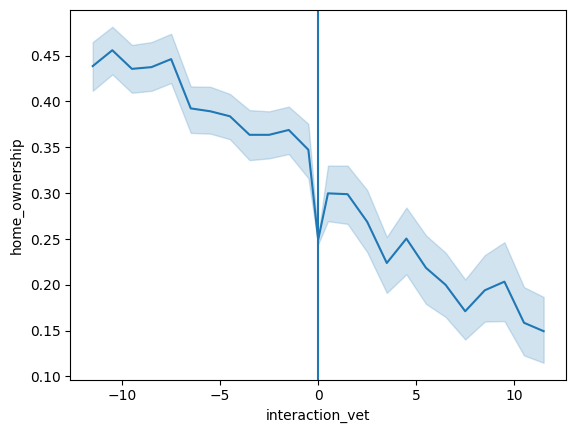

In [42]:
sns.lineplot(x = d['interaction_vet'],
             y = d['home_ownership'])
plt.axvline(0, 0, 1)

#Desnsity discontinuity test con R

In [43]:
# R CODE
#library(tidyverse ); library(rddensity)
#gt <- causaldata ::gov_transfers_density %>% filter(abs(Income_Centered) < .02)

# Estimate the discontinuity
#gt %>% pull(Income_Centered) %>% rddensity(c = 0) %>% summary()